# ARIMA Lab

Run in `py36` environment:
```
conda create -n py36 python=3.6 pandas numpy seaborn matplotlib scipy patsy statsmodels jupyter
```

### [Video Guide to this Lab](https://youtu.be/3Gw1E_BJU58)

## Time Series Modeling Process

Time series model selection is driven by the Trend and Seasonal components of our raw data. The general approach for analysis looks like this:

1. Plot the data and determine Trends and Seasonality
    1. Difference or take the log of the data (multiple times if needed) to remove trends for [certain model applications](https://en.wikipedia.org/wiki/Stationary_process)
    1. Stationairity is needed for ARMA models
1. Determine if we have additive or multiplicative data patterns
1. Select the appropriate algorithm based on the chart below
1. Determine if model selection is correct with these tools
    - Ljung-Box Test
    - Residual Errors (Normal Distribution with zero mean and constant variance-homoskedastic, i.i.d)
    - Autocorrelation Function (ACF)
    - Partial Autocorrelation Function (PACF)

Algorithm | Trend | Seasonal | Correlations
---|---|---|---
ARIMA | X |X|X
SMA Smoothing |X||
Simple Exponential Smoothing |X||
Seasonal Adjustment |X|X|
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|

In [7]:
# imports
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Prep and EDA

We'll be looking at [monthly average temperatures between 1907-1972](https://datamarket.com/data/set/22o4/mean-monthly-temperature-1907-1972#!ds=22o4&display=line)

In [8]:
# load data, recast columns if needed, convert to datetime
monthly_temp = pd.read_csv('./data/mean-monthly-temperature-1907-19.csv', skipfooter=2, 
                           infer_datetime_format=True, header=0, index_col=0, names=['month', 'temp'], engine='python')
#monthly_temp.temp = monthly_temp.temp.astype(float)
monthly_temp.index = pd.to_datetime(monthly_temp.index)

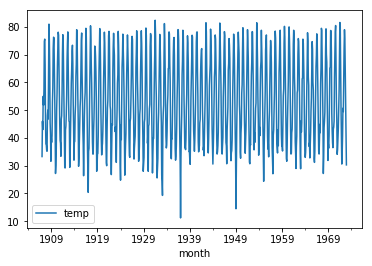

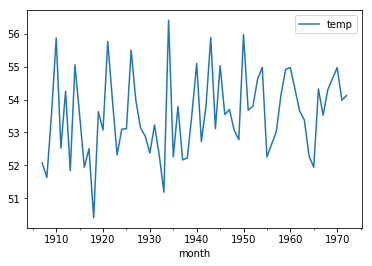

In [9]:
# resample to annual and plot each
annual_temp = monthly_temp.resample('A').mean()
monthly_temp.plot();
annual_temp.plot();

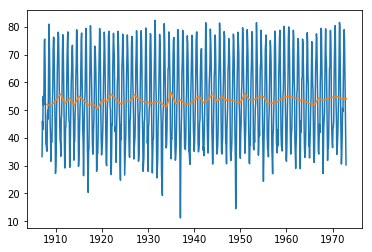

In [10]:
# plot both on same figure
plt.plot(monthly_temp)
plt.plot(annual_temp);
# note, easier to see trends on resampled or moving average charts

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


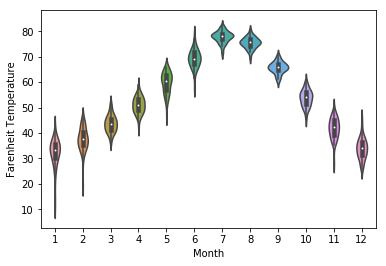

In [11]:
# violinplot months to determine variance and range
#sns.set()
sns.violinplot(x=monthly_temp.index.month, y=monthly_temp.temp)
plt.xlabel("Month")
plt.ylabel("Farenheit Temperature");

In [12]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -6.481466e+00
p-value                 1.291867e-08
Lags Used               2.100000e+01
Observations Used       7.700000e+02
Critical Value (1%)    -3.438871e+00
Critical Value (5%)    -2.865301e+00
Critical Value (10%)   -2.568773e+00
dtype: float64


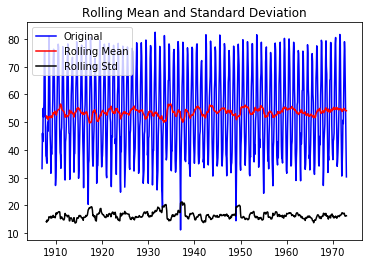

In [13]:
# run DFT on monthly
dftest(monthly_temp.temp)
# p-value allows us to reject a unit root: data is stationary

Test Statistic         -7.878242e+00
p-value                 4.779473e-12
Lags Used               0.000000e+00
Observations Used       6.500000e+01
Critical Value (1%)    -3.535217e+00
Critical Value (5%)    -2.907154e+00
Critical Value (10%)   -2.591103e+00
dtype: float64


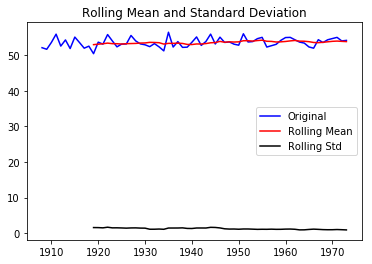

Test Statistic          -0.449458
p-value                  0.901508
Lags Used               10.000000
Observations Used       55.000000
Critical Value (1%)     -3.555273
Critical Value (5%)     -2.915731
Critical Value (10%)    -2.595670
dtype: float64


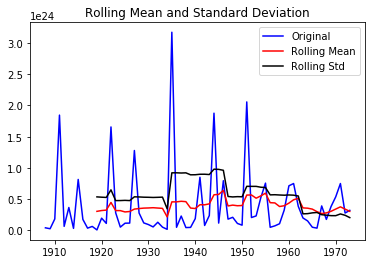

In [14]:
# run DFT on annual
dftest(annual_temp.temp)
# p-value allows us to reject a unit root: data is stationary

# here's an example of non-stationary with DFT results
dftest(np.exp(annual_temp.temp))

### Create Helper Functions

In [15]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

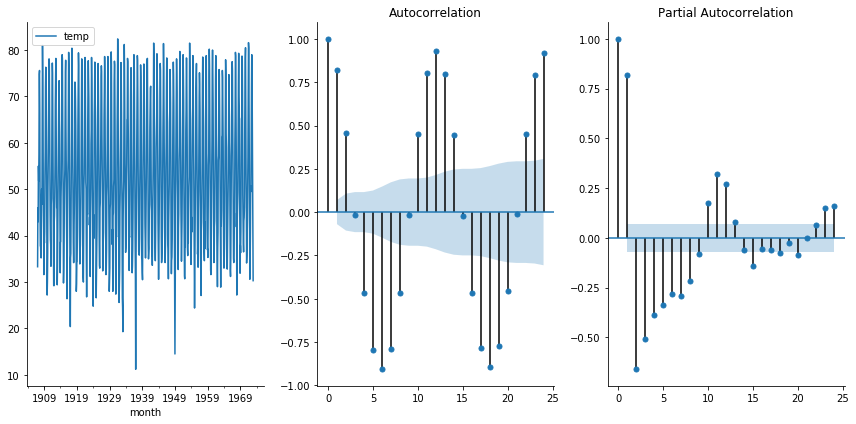

In [16]:
# helper plot for monthly temps
plots(monthly_temp, lags=24);
# open Duke guide for visual
# we note a 12-period cycle (yearly) with suspension bridge design, so must use SARIMA

### [Box-Jenkins Method](https://en.wikipedia.org/wiki/Box–Jenkins_method)

ACF Shape|Indicated Model
---|---
Exponential, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model.
Alternating positive and negative, decaying to zero|Autoregressive model. Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero|Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags|Mixed autoregressive and moving average (ARMA) model.
All zero or close to zero|Data are essentially random.
High values at fixed intervals|Include seasonal autoregressive term.
No decay to zero|Series is not stationary.

## Trying with test train validation splits

In [17]:
int(monthly_temp.shape[0]*.9)

712

In [18]:
def split_data(df):

    """Splits data into train, validation & test. Designed to get
    #2 years for validation and test, didn't want to get too close to 2009.

    INPUTS:
        df = dataframe to split
        time_loop = either 52 or 12 for weekly or monthly data to equal a year
    OUTPUTS:
        3 dfs with the data split into time ranges
    """

    df_len = df.shape[0]
    train = df.iloc[:633,:]
    validation = df.iloc[633:712,:]
    test = df.iloc[712:]
    total_len = train.shape[0]+test.shape[0]+validation.shape[0]
    if df_len == total_len:
        return train, validation, test
    else:
        return "Lengths don't match"

In [19]:
train,validation,test = split_data(monthly_temp)

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [22]:
test_model = ARIMA(train, order=(4,0,0)).fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350:

In [24]:
pred = test_model.predict(633,712)

In [27]:
validation['preds'] = pred

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [50]:
sar = sm.tsa.statespace.SARIMAX(train.temp, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [51]:
pred = sar.get_prediction(633,712)

In [52]:
validation['preds'] = pred.predicted_mean

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
def RMSE(validation_points, prediction_points):
    x = np.array(validation_points)
    y = np.array(prediction_points)
    return np.sqrt(np.mean((x - y)**2))

#got idea to try MAPE from here: https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
def MAPE(y_true,y_pred):
    y_true,y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

In [31]:
RMSE(validation.temp.values,validation.preds.values)

11.00255519976059

In [32]:
MAPE(validation.temp.values,validation.preds.values)

19.27709135722833

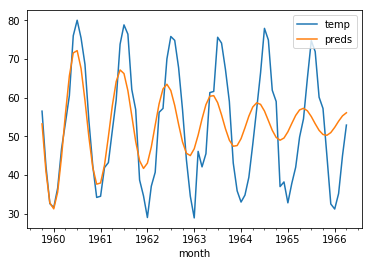

In [33]:
validation[['temp','preds']].plot()

In [49]:
monthly_temp['forecast'] = sar.predict(start = 750, end= 820, dynamic=30)  
monthly_temp[730:][['temp', 'forecast']].plot();


,temp,forecast
month,,
1907-01-01,33.3,NaN
1907-02-01,46.0,NaN
1907-03-01,43.0,NaN
1907-04-01,55.0,NaN
1907-05-01,51.8,NaN


In [22]:
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()


## Original SARIMA Lab code

In [34]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(monthly_temp.temp, order=(1,1,0), seasonal_order=(0,1,0,12), trend='c').fit()
sar.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               temp   No. Observations:                  792
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -2501.091
Date:                            Mon, 21 Jan 2019   AIC                           5008.183
Time:                                    14:10:51   BIC                           5022.157
Sample:                                01-01-1907   HQIC                          5013.558
                                     - 12-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0018      0.216      0.008      0.993      -0.421       0.424
ar.L1         -0.4314      0.029    -14.724      0.000      -0.489      -0.374
sigma2        35.9873      1.517     23.725      0.000      33.014      38.960
===================================================================================
Ljung-Box (Q):                      372.88   Jarque-Bera (JB):                28.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                             0.07
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

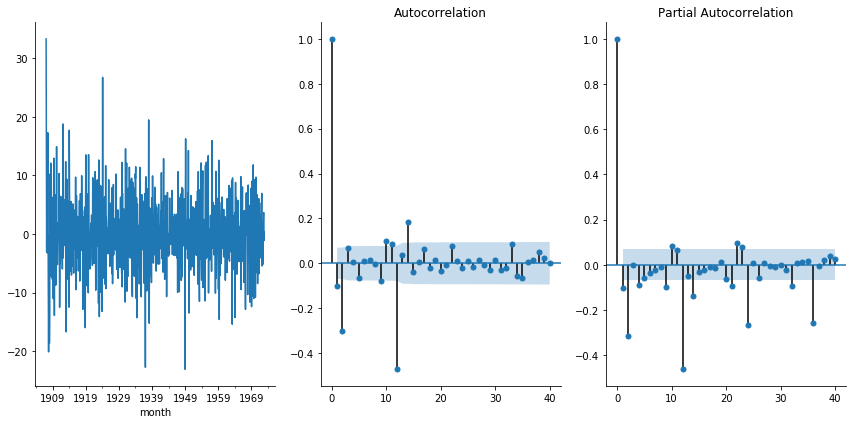

In [35]:
# plot resids
plots(sar.resid, lags=40);

# Thought process: (Reference: https://people.duke.edu/~rnau/arimrule.htm)
# 010010 is overdiff by AIC and negative ACR, but 000010 is a big underdiff with better AIC
# we pick 000010,12 and Trend='c' per rule4/5

# now look at seasonal, notice negative ACR spike at 12: per rule 13, we add a SMA term
# big drop to 4284 AIC
# looks like ACR looks good at seasonal lags, so we move back to ARIMA portion

# rule6 says we're a bit underdiff, so we add AR=3 based on PACF: 4261 AIC

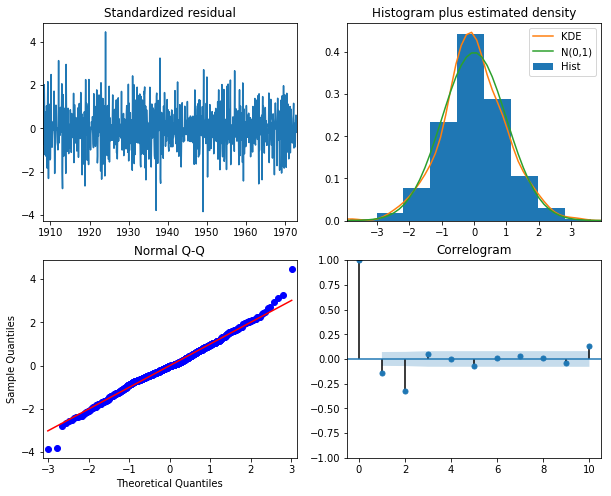

In [36]:
# plot residual diagnostics
sar.plot_diagnostics(figsize=(10, 8));

In [37]:
monthly_temp.shape

(792, 1)

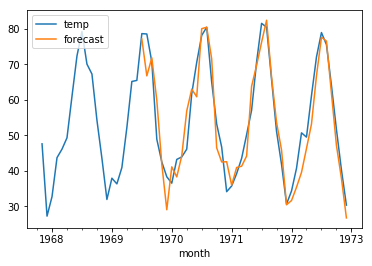

In [38]:
# plot predictions
monthly_temp['forecast'] = sar.predict(start = 750, end= 820, dynamic=30)  
monthly_temp[730:][['temp', 'forecast']].plot();

# per the documentation, we start predicting at period 750, and start a dynamic forecast at 750 + 30
# this means we use our predictions as "ground truth" for following predictions

### Statistical Tests


- [Normality (Jarque-Bera)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality)
    - Null hypothesis is normally distributed residuals (good, plays well with RMSE and similar error metrics)

- [Serial correlation (Ljung-Box)](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation)
    - Null hypothesis is no serial correlation in residuals (independent of each other)

- [Heteroskedasticity](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity)
    - Tests for change in variance between residuals.
    - The null hypothesis is of no heteroskedasticity. That means different things depending on which alternative is selected:
        - Increasing: Null hypothesis is that the variance is not increasing throughout the sample; that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.
        - Decreasing: Null hypothesis is that the variance is not decreasing throughout the sample; that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample.
        - Two-sided (default): Null hypothesis is that the variance is not changing throughout the sample. Both that the sum-of-squares in the earlier subsample is not greater than the sum-of-squares in the later subsample and that the sum-of-squares in the later subsample is not greater than the sum-of-squares in the earlier subsample.

- [Durbin Watson](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)
    - Tests autocorrelation of residuals: we want between 1-3, 2 is ideal (no serial correlation)

In [ ]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]
# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

### Note on autofit methods
R has an autoARIMA function (and other automagic methods) that gridsearches/optimizes our model hyperparameters for us. Over time, more of these goodies are porting to Python (e.g. statsmodels.tsa.x13 import x13_arima_select_order). While there's nothing wrong with utilizing these resources, the _human makes the final determination!_ Don't become over-reliant on these methods, especially early on when you are grasping the underlying mechanics and theory!

## Objectives

1. Explain time series decomposition
1. Describe additive and multiplicative data
1. Stationarize data
1. Fit AR, MA, and ARIMA models on prepared data
1. Interpret model parameters and performance
1. Visualize trends and forecasts

## Closing

- Which areas of time series modeling are most interesting?
- Which concepts are most challenging?
- How will you apply these concepts to your work or personal projects?
- Have you used other packages or tools that you've found helpful?

For more time series packages, check out the [Facebook Prophet](https://github.com/facebookincubator/prophet) and [Pyflux](http://www.pyflux.com) projects.